### CNN from scratch

- Implement convs, maxpooling, and fully connected layers
- Manually implement backpropagation for filters/weights
- ReLU

Dataset! (mnist toy dataset)

In [1]:
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [3]:
train.data.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

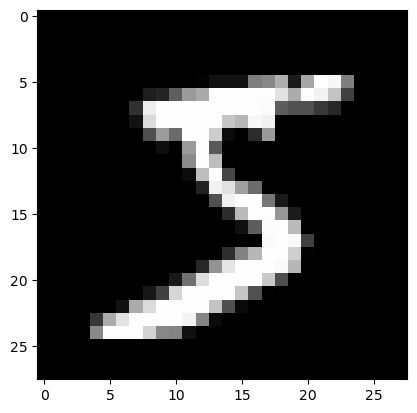

In [4]:
# see one image in the dataset
plt.imshow(train.data[0].numpy(), cmap='gray')

~~Just curious what does Imagenet look like in terms of dims~~ using cifar10 instead since it's smaller

In [5]:
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
# cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified


In [6]:
cifar_train.data.shape

(50000, 32, 32, 3)

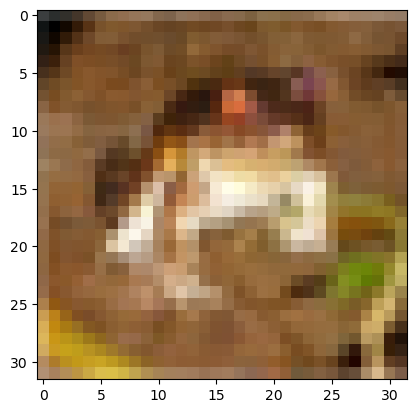

In [7]:
plt.imshow(cifar_train.data[0]) # cute

Conv

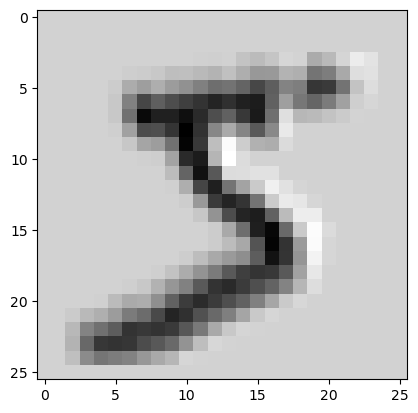

In [14]:
f = torch.randn(3, 3)
image = train.data[0] # (28, 28)
out = torch.zeros(26, 26)

# perform a simple convolution with mnist sample
for i in range(1,27): # image.shape[0]-1, output will have size 26
  for j in range(1,27):
    out[i-1, j-1] = torch.sum(f * image[i-1:i+2, j-1:j+2])

plt.imshow(out.numpy(), cmap='gray')

In [15]:
# check if approx equal
# need to unsqueeze for batch and channel dims
check = F.conv2d(image.unsqueeze(0).unsqueeze(0).float(), f.unsqueeze(0).unsqueeze(0))
torch.allclose(out, check.squeeze(), 1e-6) # yayyy

True

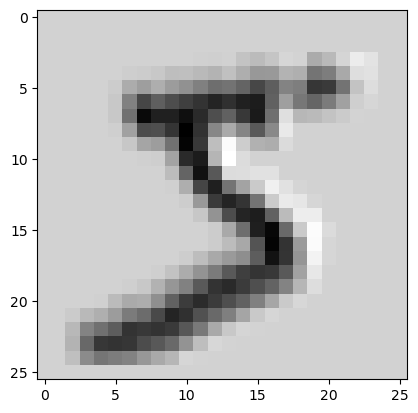

In [16]:
plt.imshow(check.squeeze().detach().numpy(), cmap='gray')

In [17]:
# generalized conv
def conv2d(image, kernel, stride=1, padding=0):
  w, h = image.shape
  w_k, h_k = kernel.shape
  w_out, h_out = (w + 2*padding - w_k)//stride + 1, (h + 2*padding - h_k)//stride + 1 # (W-F+2P)/S + 1

  out = torch.zeros(w_out, h_out)
  for i in range(w_out):
    for j in range(h_out):
      out[i, j] = torch.sum(kernel * image[i*stride:i*stride+w_k, j*stride:j*stride+h_k])
  return out

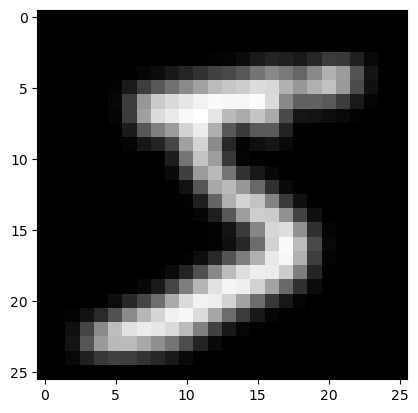

In [18]:
gaussian = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
blurred = conv2d(image, gaussian, stride=1, padding=0)
plt.imshow(blurred.numpy(), cmap='gray')

Conv2d layer

In [6]:
class Conv2d(torch.nn.Module):
  """ Convolutional layer for 2D images """
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super().__init__()
    self.in_channels = in_channels # number of input channels, ex 3 for RGB
    self.out_channels = out_channels # number of filters, ex 32
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding

    self.weights = torch.randn(out_channels, in_channels, kernel_size, kernel_size)
    self.bias = torch.randn(out_channels)

  def forward(self, x):
    batch_size, _, height, width = x.shape
    out_height = (height + 2*self.padding - self.kernel_size)//self.stride + 1
    out_width = (width + 2*self.padding - self.kernel_size)//self.stride + 1

    x = F.pad(x, (self.padding, self.padding, self.padding, self.padding)) # pad the input
    out = torch.zeros(batch_size, self.out_channels, out_height, out_width)
  
    print(self.weights.shape, x.shape, out.shape)
  
    for image in range(batch_size):
      for i in range(out_height):
        for j in range(out_width):
          # (out, in, kernel, kernel) * (batch_size, in, kernel, kernel) = (batch_size, out, kernel, kernel) because of broadcasting
          out[image, :, i, j] = torch.sum(self.weights * x[image, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size], dim=(1,2,3)) + self.bias
    return out

In [81]:
a = torch.randn(1, 3, 244, 244)
b = torch.randn(64, 3, 3, 3)

c = torch.sum(b*a[:, :, 0:3, 0:3], dim=(1,2,3))
print("one 'sliding window' of the conv", c.shape) # would be (64, 244, 244) if we did it for the whole image

# add padding to a
a = F.pad(a, (1,1,1,1))
cout = torch.zeros(1, 64, 244, 244)
cout[:, :, i, j] = torch.sum(b * a[:, :, i:i+3, j:j+3], dim=(1,2,3)) # vectorized for loop; for each filter, for each pixel, do the convolution
# dim is necessary because we want to sum over the channels and kernels not the batches
print("output of the conv", cout.shape)

one 'sliding window' of the conv torch.Size([64])
output of the conv torch.Size([1, 64, 244, 244])


In [82]:
# test out the conv layer

# create a conv layer
conv = Conv2d(1, 8, 3, stride=1, padding=1)

# forward pass
out = conv(image.unsqueeze(0).unsqueeze(0).float())
print(out.shape)

# plot each filter on same plot
fig = plt.figure(figsize=(10, 10))
for i in range(8):
  fig.add_subplot(1, 8, i+1)
  plt.imshow(conv.weights[i].squeeze().detach().numpy(), cmap='gray')

# plot the output activations on same plot
fig = plt.figure(figsize=(10, 10))
for i in range(8):
  fig.add_subplot(1, 8, i+1)
  plt.imshow(out[0, i].detach().numpy(), cmap='gray')

# check if approx equal
check = F.conv2d(image.unsqueeze(0).unsqueeze(0).float(), conv.weights, bias=conv.bias, stride=conv.stride, padding=conv.padding)
torch.allclose(out, check, 1e-6) # why is this not true?

AttributeError: 'int' object has no attribute 'unsqueeze'

In [29]:
# test with 3 channels
conv2 = Conv2d(3, 8, 3, stride=1, padding=1)
out2 = conv2(torch.tensor(cifar_train.data[:1].transpose(0,3,1,2).astype('float32')))
out2.shape

torch.Size([1, 8, 32, 32])

Is this right? is it actually taking info from all 3 channels or just one?

Realized that yes, it is actually using a weight which includes in_channels, so it's taking info from all 3 channels

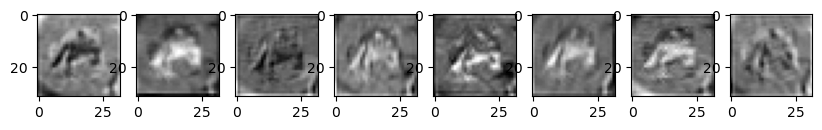

In [31]:
# show all 3 channels <- nvm I'm showing the feature activations which are already summed across 3 channels#
fig = plt.figure(figsize=(10, 10))
for i in range(8):
  # fig.add_subplot(1, 3, i+1)
  # plt.imshow(cifar_train.data[0].transpose(2,0,1)[i], cmap='gray') # this actually made me laugh out loud... 3 frogs
  fig.add_subplot(1, 8, i+1)
  plt.imshow(out2[0, i].detach().numpy(), cmap='gray')

Pooling layer (very similar to conv2d except instead of torch.sum we use torch.max and we don't multiply by weights)

In [7]:
class Pooling(torch.nn.Module):
  """ Pooling layer for 2D images """
  def __init__(self, kernel_size, stride=None, padding=0):
    super().__init__()
    self.kernel_size = kernel_size
    self.stride = stride if stride else kernel_size
    self.padding = padding

  def forward(self, x):
    # x.shape = (batch_size, in_channels, height, width)
    batch_size, in_channels, height, width = x.shape
    out_height = (height + 2*self.padding - self.kernel_size)//self.stride + 1
    out_width = (width + 2*self.padding - self.kernel_size)//self.stride + 1

    x = F.pad(x, (self.padding, self.padding, self.padding, self.padding)) # pad the input
    out = torch.zeros(batch_size, in_channels, out_height, out_width)
    
    print(x.shape, out.shape)

    for image in range(batch_size):
      for channel in range(in_channels):
        for i in range(out_height):
          for j in range(out_width):
            out[image, channel, i, j] = torch.max(x[image, channel, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size])
    return out

In [77]:
img = torch.randn(4, 3, 244, 244) # original batch of images we want to pool

p = torch.zeros(4, 3, 122, 122) # pooled images

for image in range(4):
  for i in range(122):
    for j in range(122):
      # want to get max of 2x2 window
      window = img[image, :, i*2:i*2+2, j*2:j*2+2]
      print(window)
      for channel in range(3):
        p[image, channel, i, j] = torch.max(window[channel])
      break

tensor([[[ 1.0626, -1.4224],
         [-0.8256,  1.0793]],

        [[ 0.8611,  0.1837],
         [ 0.8767,  0.3047]],

        [[ 0.2933, -0.0117],
         [ 0.9647,  0.5509]]])
tensor([[[-0.5958,  0.2310],
         [-1.2078, -0.6274]],

        [[-0.5082, -0.4024],
         [ 0.4316,  0.6698]],

        [[-0.7656, -0.4967],
         [ 0.0920, -1.2951]]])
tensor([[[ 0.4215,  1.1140],
         [ 0.0933,  1.5119]],

        [[-0.6585, -0.8278],
         [-0.8858,  0.4709]],

        [[-1.4449, -0.1016],
         [-0.7150,  0.2874]]])
tensor([[[-0.6209,  0.0641],
         [ 0.3703,  2.2031]],

        [[ 0.2379, -1.2167],
         [ 0.9378, -0.3539]],

        [[ 0.2314, -0.7004],
         [ 0.5025,  0.9553]]])
tensor([[[-0.9851,  0.6150],
         [-0.1236, -0.1001]],

        [[-0.6631,  3.5491],
         [ 0.5682,  0.6027]],

        [[-0.6113,  1.6989],
         [ 0.3846,  0.7062]]])
tensor([[[ 1.5427, -0.2109],
         [-0.7040, -1.0638]],

        [[ 0.8227, -0.4595],
         [ 

Linear layer (a very simple cute layer :) )

In [8]:
class Linear(torch.nn.Module):
  """ Linear layer """
  def __init__(self, in_features, out_features):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weights = torch.randn(out_features, in_features)
    self.bias = torch.randn(out_features)

  def forward(self, x):
    # x.shape = (batch_size, in_features)
    return torch.matmul(x, self.weights.T) + self.bias

In [9]:
class Flatten(torch.nn.Module):
  """ Flatten layer """
  def __init__(self):
    super().__init__()

  def forward(self, x):
    # x.shape = (batch_size, in_features)
    return x.view(x.shape[0], -1)

Now we have everything we need to build a CNN!

Let's create a VGG16

In [10]:
class VGG16(torch.nn.Module):
  """ VGG16 model """
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = Conv2d(3, 64, 3, stride=1, padding=1)
    self.conv2 = Conv2d(64, 64, 3, stride=1, padding=1)
    self.pool1 = Pooling(2, stride=2)
    self.conv3 = Conv2d(64, 128, 3, stride=1, padding=1)
    self.conv4 = Conv2d(128, 128, 3, stride=1, padding=1)
    self.pool2 = Pooling(2, stride=2)
    self.conv5 = Conv2d(128, 256, 3, stride=1, padding=1)
    self.conv6 = Conv2d(256, 256, 3, stride=1, padding=1)
    self.conv7 = Conv2d(256, 256, 3, stride=1, padding=1)
    self.pool3 = Pooling(2, stride=2)
    self.conv8 = Conv2d(256, 512, 3, stride=1, padding=1)
    self.conv9 = Conv2d(512, 512, 3, stride=1, padding=1)
    self.conv10 = Conv2d(512, 512, 3, stride=1, padding=1)
    self.pool4 = Pooling(2, stride=2)
    self.conv11 = Conv2d(512, 512, 3, stride=1, padding=1)
    self.conv12 = Conv2d(512, 512, 3, stride=1, padding=1)
    self.conv13 = Conv2d(512, 512, 3, stride=1, padding=1)
    self.pool5 = Pooling(2, stride=2)
    self.flatten = Flatten()
    self.fc1 = Linear(512, 4096)
    self.fc2 = Linear(4096, 4096)
    self.fc3 = Linear(4096, num_classes)

  def forward(self, x):
    # x.shape = (batch_size, 3, 224, 224)
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.pool1(out)
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.pool2(out)
    out = F.relu(self.conv5(out))
    out = F.relu(self.conv6(out))
    out = F.relu(self.conv7(out))
    out = self.pool3(out)
    out = F.relu(self.conv8(out))
    out = F.relu(self.conv9(out))
    out = F.relu(self.conv10(out))
    out = self.pool4(out)
    out = F.relu(self.conv11(out))
    out = F.relu(self.conv12(out))
    out = F.relu(self.conv13(out))
    out = self.pool5(out)
    out = self.flatten(out)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [11]:
# create model

model = VGG16()

# run model on a batch of images

import numpy as np
batch = torch.tensor(cifar_train.data[:4].transpose(0,3,1,2).astype(np.float32))/255
print(batch.shape)
out = model(batch)

# for debugging I'm printing out weights.shape, x.shape, out.shape

torch.Size([4, 3, 32, 32])
torch.Size([64, 3, 3, 3]) torch.Size([4, 3, 34, 34]) torch.Size([4, 64, 32, 32])
torch.Size([64, 64, 3, 3]) torch.Size([4, 64, 34, 34]) torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32]) torch.Size([4, 64, 16, 16])
torch.Size([128, 64, 3, 3]) torch.Size([4, 64, 18, 18]) torch.Size([4, 128, 16, 16])
torch.Size([128, 128, 3, 3]) torch.Size([4, 128, 18, 18]) torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16]) torch.Size([4, 128, 8, 8])
torch.Size([256, 128, 3, 3]) torch.Size([4, 128, 10, 10]) torch.Size([4, 256, 8, 8])
torch.Size([256, 256, 3, 3]) torch.Size([4, 256, 10, 10]) torch.Size([4, 256, 8, 8])
torch.Size([256, 256, 3, 3]) torch.Size([4, 256, 10, 10]) torch.Size([4, 256, 8, 8])
torch.Size([4, 256, 8, 8]) torch.Size([4, 256, 4, 4])
torch.Size([512, 256, 3, 3]) torch.Size([4, 256, 6, 6]) torch.Size([4, 512, 4, 4])
torch.Size([512, 512, 3, 3]) torch.Size([4, 512, 6, 6]) torch.Size([4, 512, 4, 4])
torch.Size([512, 512, 3, 3]) torch.Size([4, 512, 6

Ran into some trouble with batch size, here it is fixed

In [38]:
a = torch.randn(4, 3, 32, 32) # images
b = torch.randn(64, 3, 3, 3) # weights/filters

# can't do this because of batch size greater than 1
# c = torch.sum(b * a[:, :, 0:3, 0:3], dim=(1,2,3)) # sum over the channels and kernels
# print("one 'sliding window' of the conv", c.shape) # would be (64, 244, 244) if we did it for the whole image

# add padding to a
a = F.pad(a, (1,1,1,1))
cout = torch.zeros(4, 64, 32, 32)

# cout[:, :, i, j] = torch.sum(b * a[:, :, i:i+3, j:j+3], dim=(1,2,3)) # vectorized for loop; for each filter, for each pixel, do the convolution
for image in range(a.shape[0]):
  cout[image, :, i, j] = torch.sum(b * a[image, :, i:i+3, j:j+3], dim=(1,2,3))

# can I vectorize this to remove the for loop?
# vectorized for loop; for each image in the batch, for each filter, for each pixel, do the convolution
# cout = torch.zeros(4, 64, 32, 32)
# cout[image, :, i, j] = torch.sum(b * a[image, :, i:i+3, j:j+3], dim=(1,2,3))

print("output of the conv", cout.shape)

output of the conv torch.Size([4, 64, 32, 32])


In [15]:
# from torchsummary import summary

# summary(model, (3, 224, 224), device='cpu')

# from torchinfo import summary
# summary(model, input_size=(4, 3, 224, 224))